# Dataverwerking RC en RLC keten

### Importeren packages

In [7]:
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy.optimize as opt
import scipy.stats as nst

sp.init_printing()

In [2]:
%matplotlib notebook

In [2]:
mpl.rcParams['figure.dpi'] = 200

## RC-keten: blokgolf

### Importeren data

In [3]:
frame = pd.read_csv("data/RC.csv")

In [4]:
cols = frame.columns
cols

Index(['Laatste: Tijd (s)', 'Laatste: Potential 1 (V)',
       'Laatste: Potential 2 (V)'],
      dtype='object')

### plot voor checken data

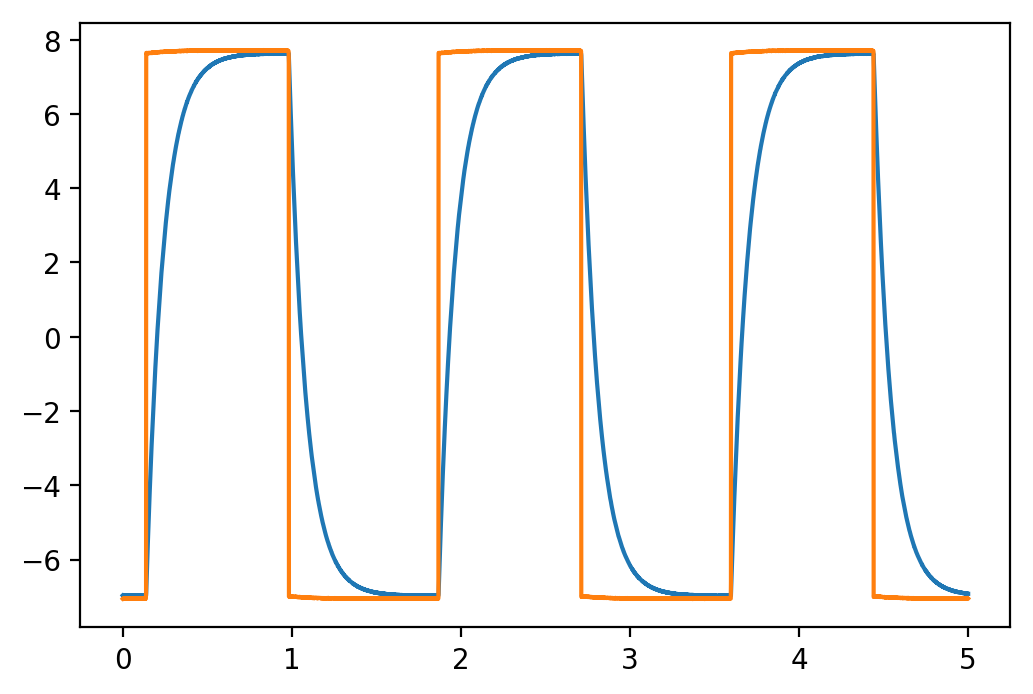

In [5]:
fig, ax = plt.subplots(1,1)

ax.plot(frame[cols[0]], frame[cols[1]])
ax.plot(frame[cols[0]], frame[cols[2]])

plt.show()

### fitten van een oplaadcurve

In [6]:
# functie die het op/ontladen van de condensator beschrijft
def charge(t, A, B, tau):
    return B + A*np.exp(-t/tau)

In [7]:
# selecteer enkel de delen waar de condensator oplaadt
opladen = frame.loc[(5 < frame[cols[2]])]
# selecteer de eerste blokgolf
opladen = opladen.loc[(frame[cols[0]] < 1.5)]

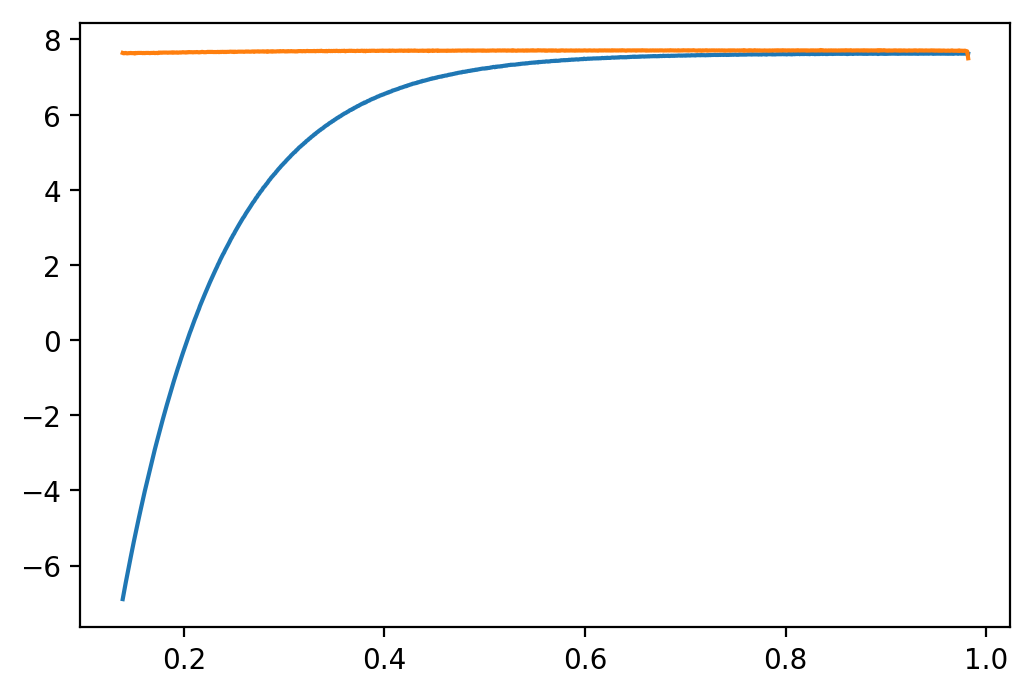

In [8]:
fig, ax = plt.subplots(1,1)

ax.plot(opladen[cols[0]], opladen[cols[1]])
ax.plot(opladen[cols[0]], opladen[cols[2]])

plt.show()

Fit de curve door de data

In [9]:
params, covar = opt.curve_fit(charge, opladen[cols[0]].values, opladen[cols[1]].values, (-8, 8, 0.1))

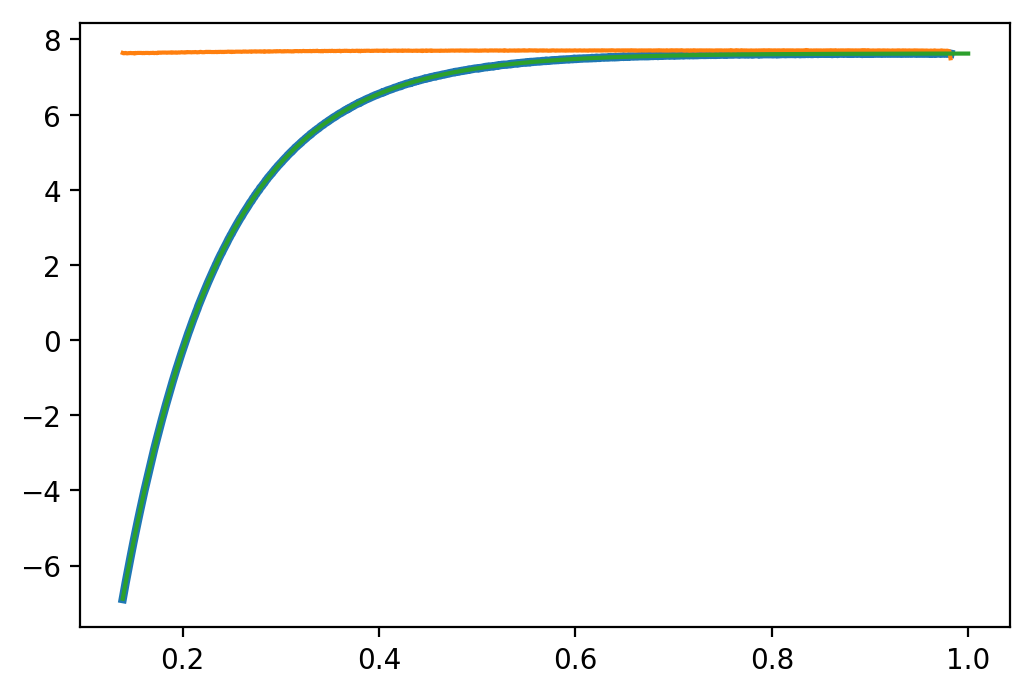

In [10]:
fig, ax = plt.subplots(1,1)

ax.plot(opladen[cols[0]], opladen[cols[1]], linewidth=3)
ax.plot(opladen[cols[0]], opladen[cols[2]])
T = np.linspace(np.min(opladen[cols[0]]), 1, 1000)
ax.plot(T, charge(T, *params), linewidth=1.5)

plt.show()

Print de karakteristieke tijd met fout

In [11]:
print("karakteristieke tijd: %f s +- %f" %(params[2], np.sqrt(covar[2,2])))

karakteristieke tijd: 0.100213 s +- 0.000008


## reactie CR-keten op sinusgolf

### Importeren data

In [19]:
nums = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 
       150, 160, 170, 180, 200, 300, 400, 500]
frames = [pd.read_csv("data_gekuist/CR%d.csv" %num) for num in nums]
# zet alles in milliseconden
frames[0][frames[0].columns[0]] *= 1000
frames[1][frames[1].columns[0]] *= 1000

### fitten curves

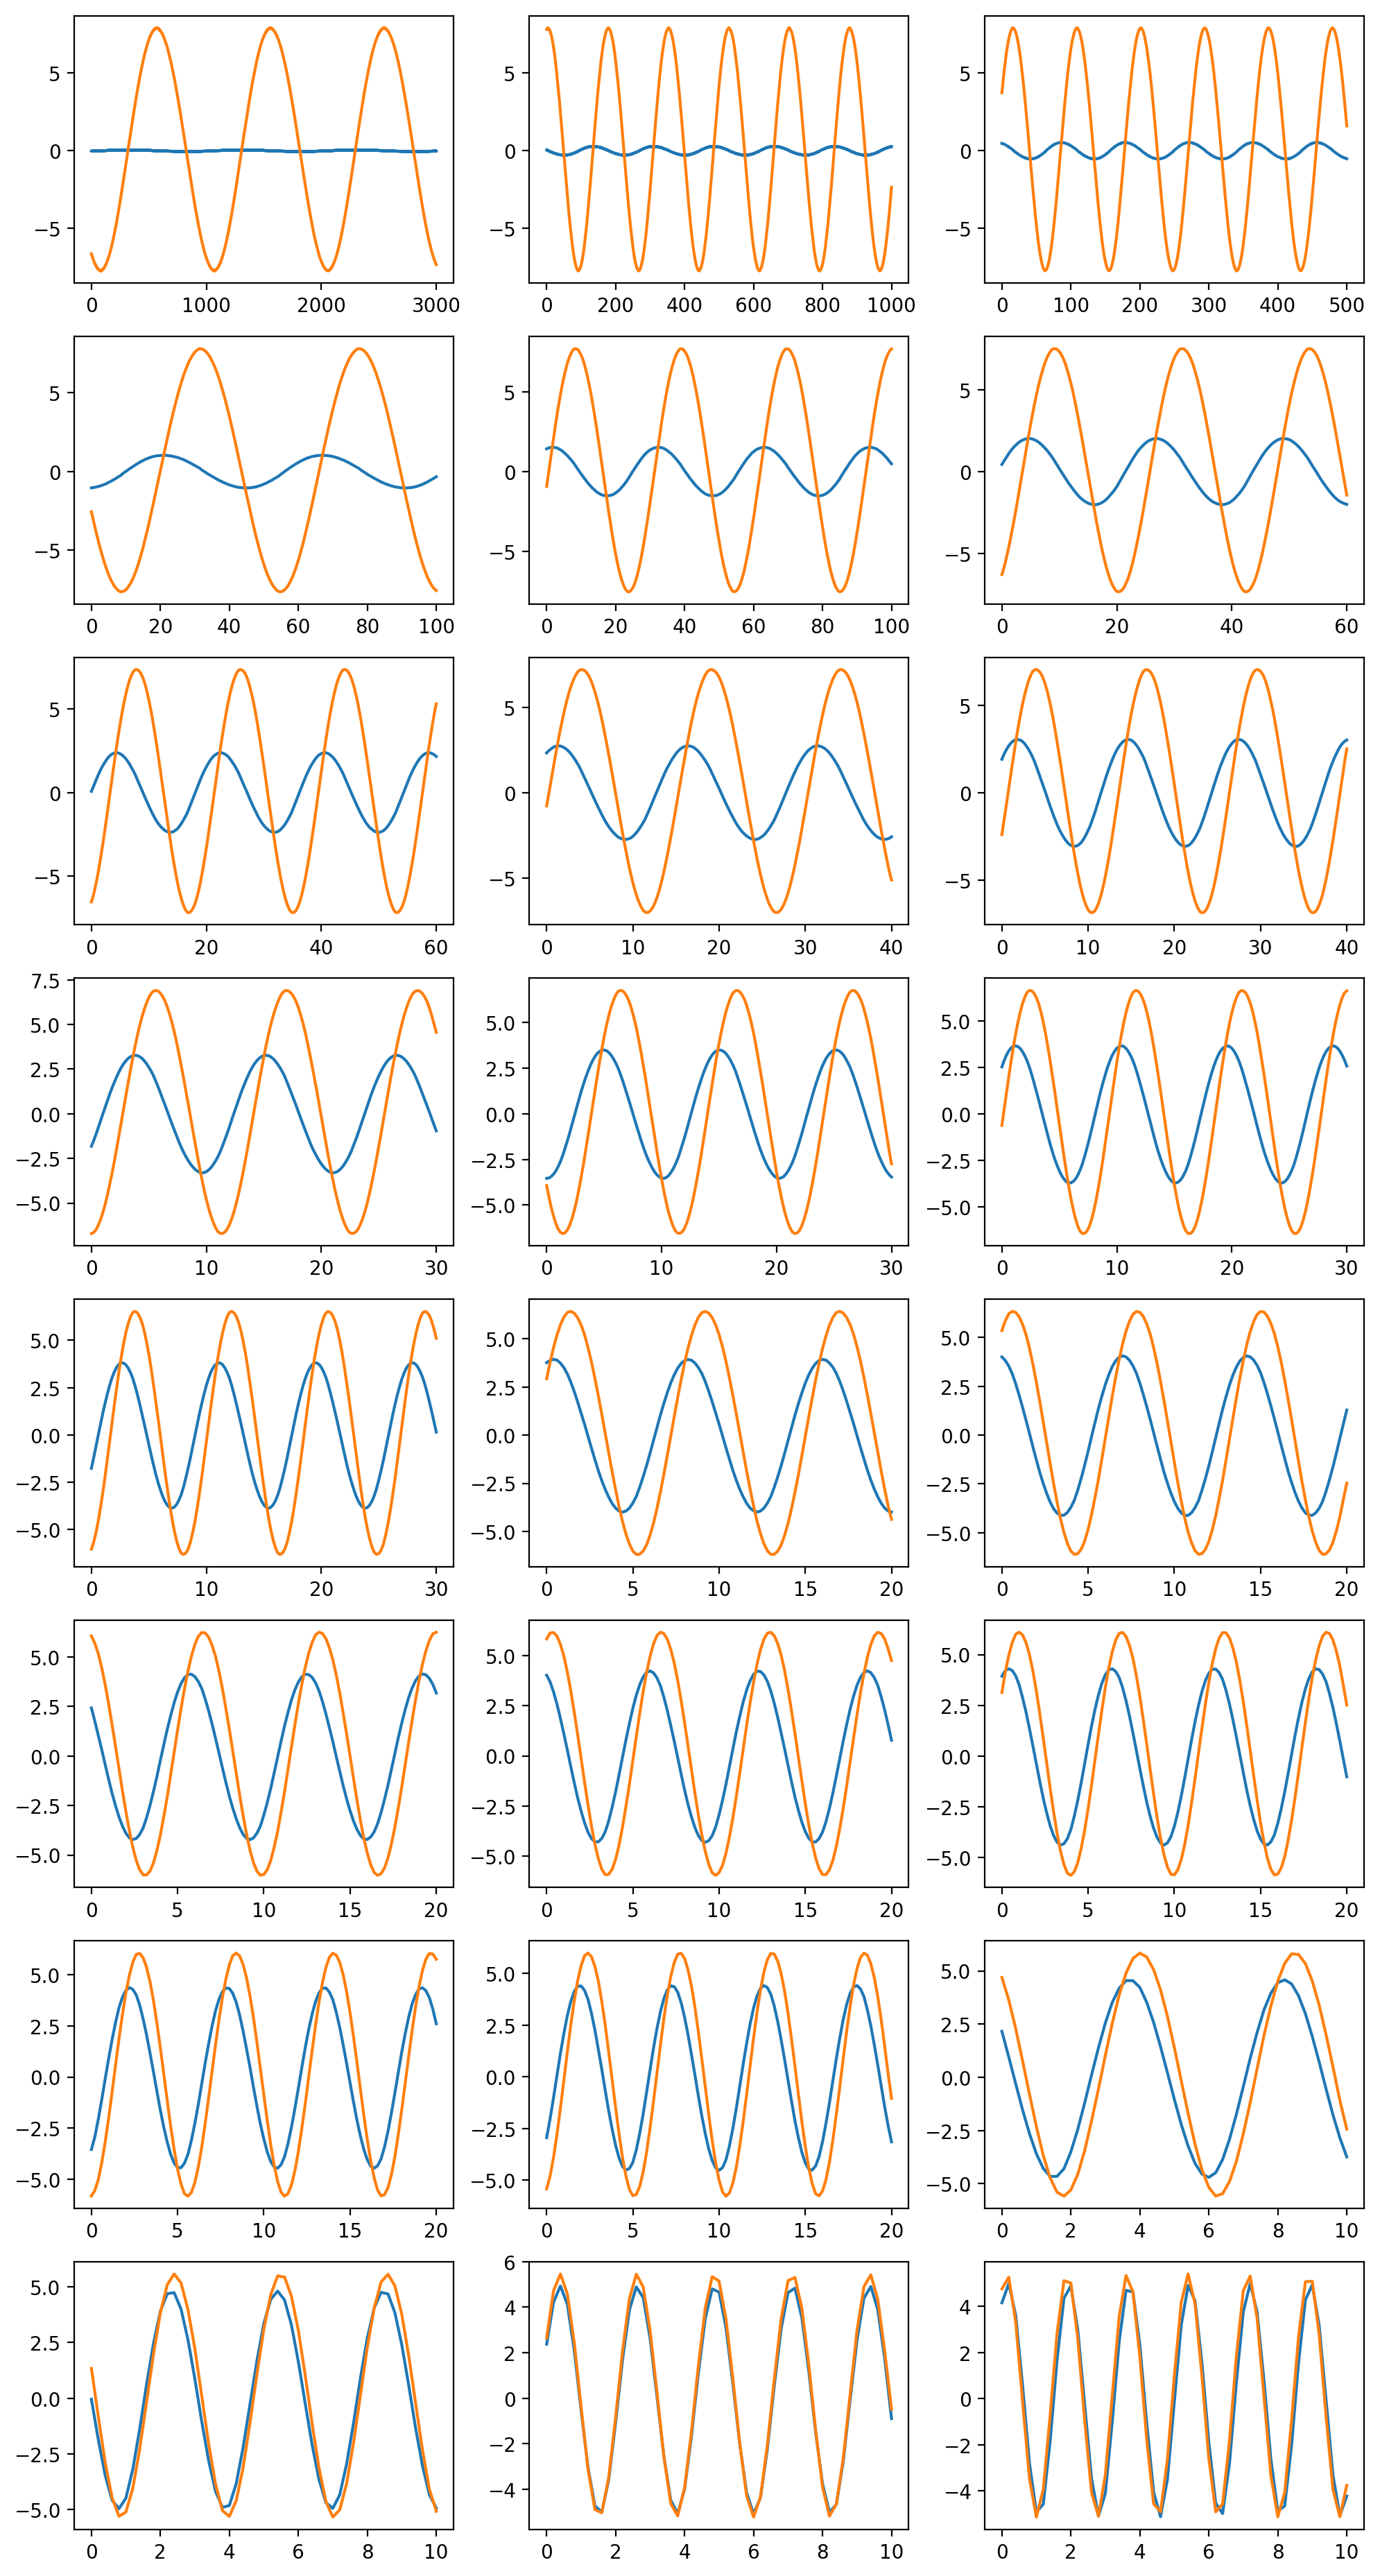

In [18]:
fig, axes = plt.subplots(8,3, figsize=(12, 24))

for i in range(24):
    num = nums[i]
    frame = frames[i]
    cols = frame.columns
    
    ax = axes[i//3][i%3]

    ax.plot(frame[cols[0]], frame[cols[1]])
    ax.plot(frame[cols[0]], frame[cols[2]])

plt.show()

fig.savefig("CR-circuit-frequenties.png")

De te fitten sinusfunctie

In [20]:
def spanning(t, omega, phi, A):
    return A*np.sin(omega*t-phi)

Fit voor elke plot beide functies

In [33]:
params1 = {i : [] for i in nums}
covars1 = {i : [] for i in nums}
params2 = {i : [] for i in nums}
covars2 = {i : [] for i in nums}


for i in range(24):
    num = nums[i]
    frame = frames[i]
    T = frame[frame.columns[0]]
    V1 = frame[frame.columns[1]]
    V2 = frame[frame.columns[2]]
    param1, covar1 = opt.curve_fit(spanning, T, V1, (num*2*np.pi/1000, 0, 5))
    param2, covar2 = opt.curve_fit(spanning, T, V2, (num*2*np.pi/1000, 0, 8))
    params1[num] = param1
    params2[num] = param2
    covars1[num] = covar1
    covars2[num] = covar2
    
# fiks de voorlaatste fit
num = nums[22]
frame = frames[22]
T = frame[frame.columns[0]]
V1 = frame[frame.columns[1]]
V2 = frame[frame.columns[2]]
param1, covar1 = opt.curve_fit(spanning, T, V1, (num*2*np.pi/1000, -np.pi/3*num*2*np.pi/1000, 5))
param2, covar2 = opt.curve_fit(spanning, T, V2, (num*2*np.pi/1000, 0, 8))
params1[num] = param1
params2[num] = param2
covars1[num] = covar1
covars2[num] = covar2

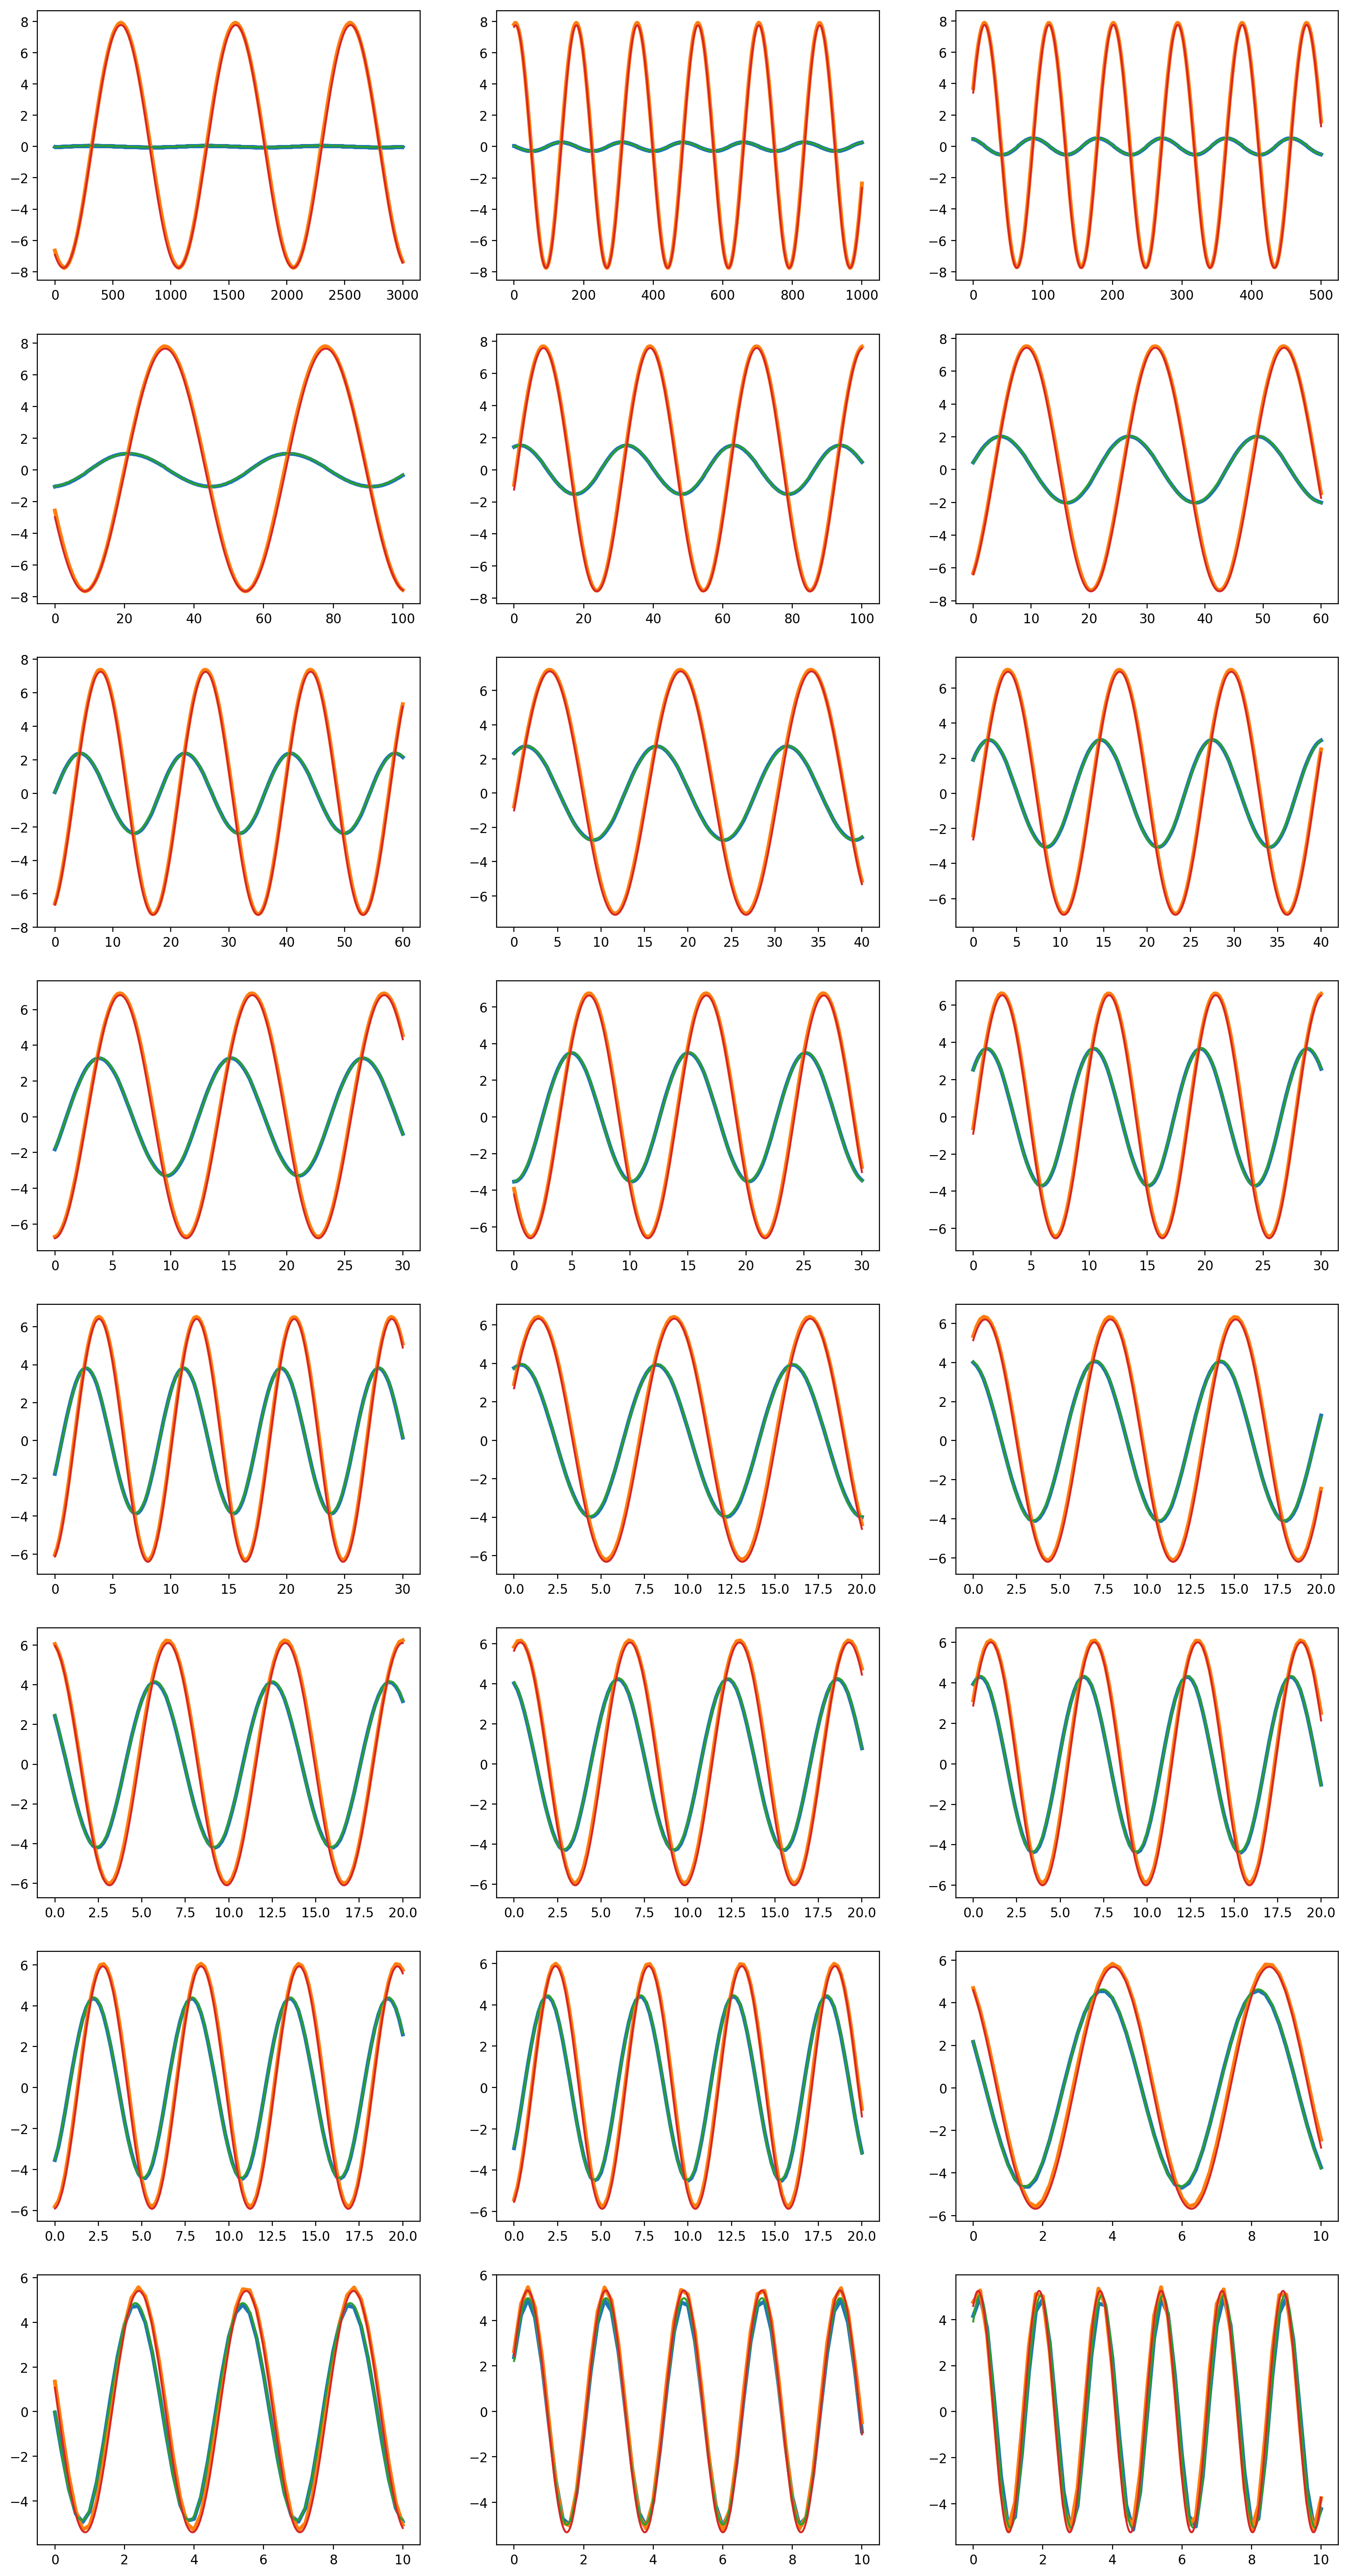

In [46]:
fig, axes = plt.subplots(8,3, figsize=(18, 36))

for i in range(24):
    num = nums[i]
    frame = frames[i]
    cols = frame.columns
    
    ax = axes[i//3][i%3]

    ax.plot(frame[cols[0]], frame[cols[1]], linewidth=3)
    ax.plot(frame[cols[0]], frame[cols[2]], linewidth=3)
    T = np.linspace(np.min(frame[cols[0]]), np.max(frame[cols[0]]), 1000)
    ax.plot(T, spanning(T, *params1[num]))
    ax.plot(T, spanning(T, *params2[num]))

plt.show()

fig.savefig("CR-circuit-frequenties.pdf")

Plot van amplitude uit Vs frequentie

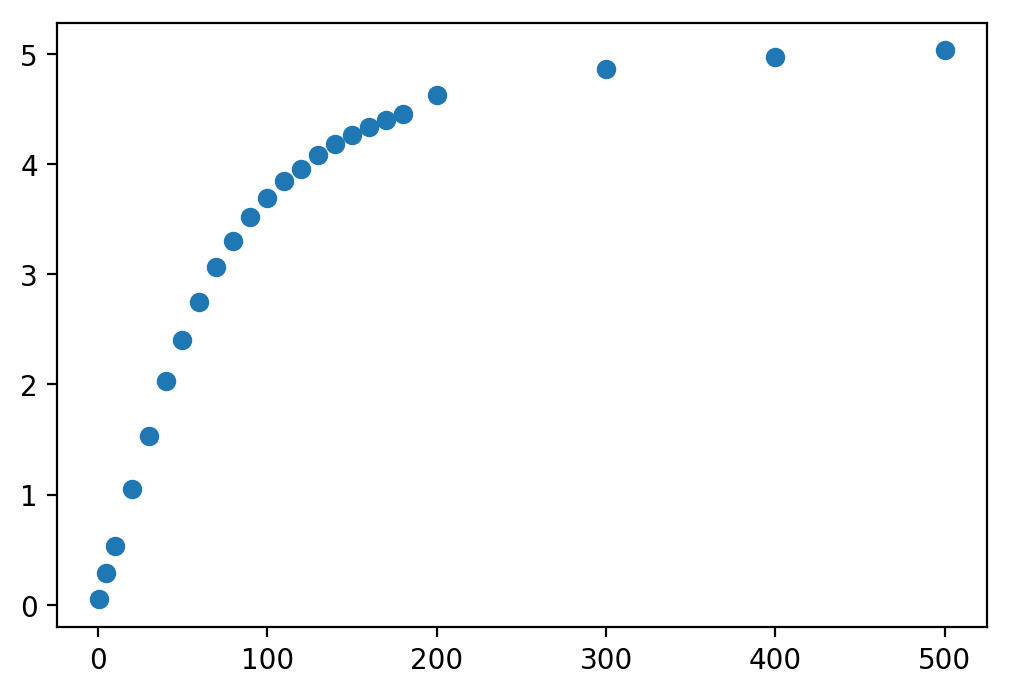

In [38]:
fig, ax = plt.subplots(1,1)

ax.plot(nums, [np.abs(params1[num][2]) for num in nums], 'o')

plt.show()

In [49]:
for num in nums:
    print("%f, %f" %(params1[num][1]*np.sign(params1[num][2]) % 2*np.pi, 
                     params2[num][1]*np.sign(params2[num][2]) % 2*np.pi))

1.905244, 0.126217
4.212563, 0.843939
2.550912, 4.845061
4.236705, 1.251223
0.112573, 0.516082
5.625121, 3.257126
6.193877, 3.645952
4.141575, 0.448128
4.216029, 1.224412
1.744919, 4.818149
4.822660, 1.401317
3.950337, 0.438693
1.422719, 3.999580
2.438507, 4.895680
1.839522, 3.212446
4.274216, 2.020259
2.299894, 3.398385
2.752563, 4.713299
2.893427, 4.704886
2.183175, 3.864085
4.725907, 3.336831
6.271582, 5.656615
4.837067, 4.191177
5.485650, 6.041932


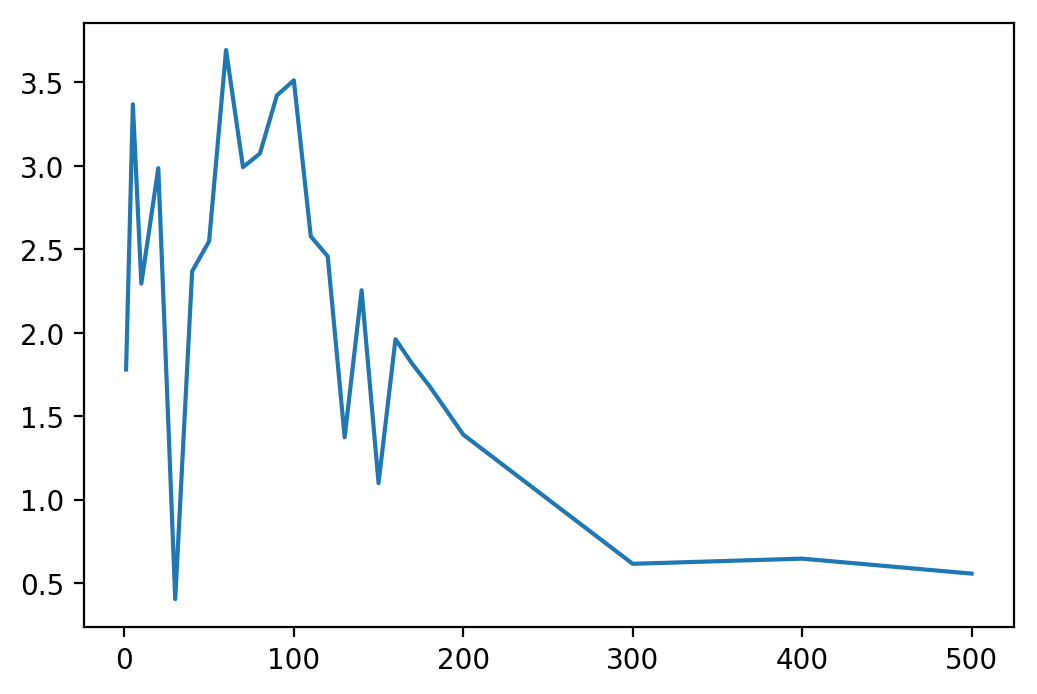

In [52]:
fig, ax = plt.subplots(1,1)

ax.plot(nums, [np.abs((params1[num][1]*np.sign(params1[num][2]) % 2*np.pi - 
                     params2[num][1]*np.sign(params2[num][2]) % 2*np.pi)) for num in nums])

plt.show()

<IPython.core.display.Javascript object>


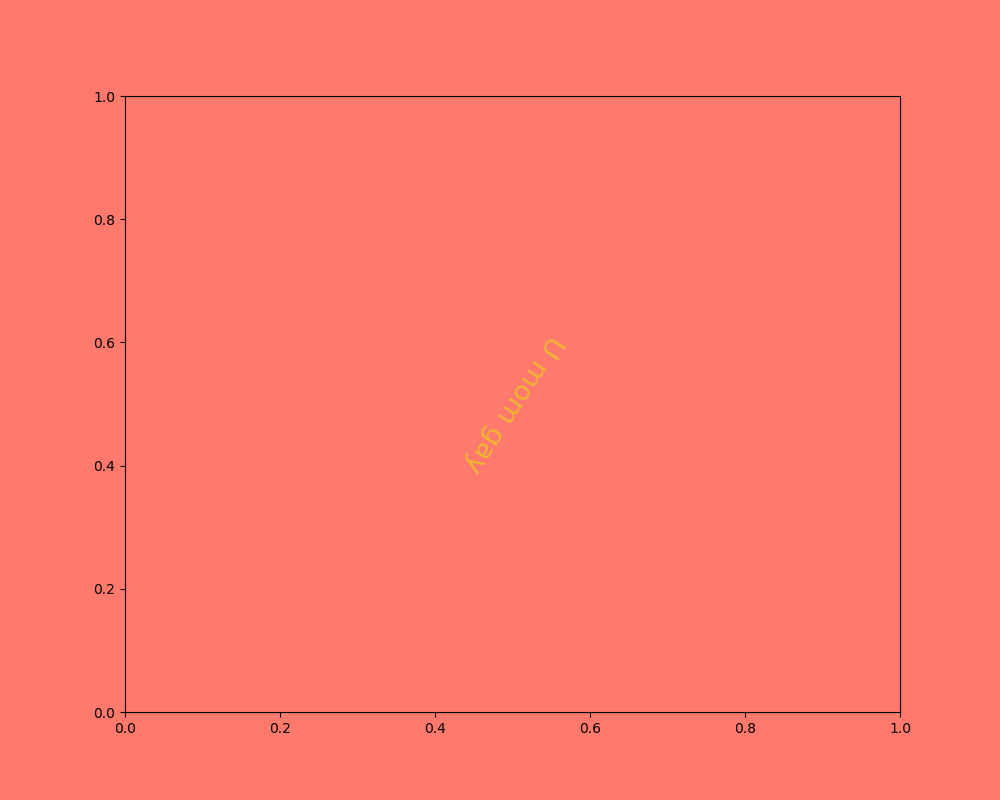

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.set_ylim(0,1)
ax.set_xlim(0,1)
fig.set_facecolor("xkcd:salmon")
ax.set_facecolor("xkcd:salmon")

text = ax.text(0.5, 0.5, "U mom gay", size=0, color="xkcd:macaroni and cheese", verticalalignment="center",
              horizontalalignment="center")

def animate(i):
    text.set_size((i/4)%120)
    text.set_rotation(3*i)

anim = animation.FuncAnimation(fig, animate, frames=1000, interval=40)
plt.show()

nums = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 
       150, 160, 170, 180, 200, 300, 400, 500]

for num in nums:
    temp = pd.read_csv("data/CR%d.csv" %num, sep=";", decimal=",")
    cols = temp.columns
    i = 0
    frame = temp[[cols[3*i], cols[3*i+1], cols[3*i+2]]]
    frame = frame.dropna()
    frame.to_csv("data_gekuist/CR%d.csv" %num, index=False)